## Amazon Review Data : Data Exploration

### Setup spark

In [53]:
# Import libraries
import os, pickle, glob
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, SQLContext, DataFrame
from pyspark.sql.types import StringType
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.stat import Summarizer
from pyspark.ml.feature import Word2Vec, Tokenizer, StringIndexer, OneHotEncoder, PCA, VectorAssembler

In [54]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "128g") \
	.config("spark.executor.memory", "64g") \
    .config('spark.executor.instances', 64) \
	.appName("Amazon Reviews") \
	.getOrCreate()

In [55]:
sqlContext = SQLContext(sc)

## Read Data

### Get files

In [56]:
#######################################################################################
###################### change path to: "../clin6/amazon_data" #########################
#######################################################################################
# path = "../clin6/amazon_data"
path = "amazon_data"

In [57]:
def read(path):
    """
    Method that loads data file as df
    Takes in 1 parameter: path
    """
    return sc.read.csv(path, sep = "\t", header = True, inferSchema = True)

def get_path(file):
    """
    Method to create path
    Takes in 1 parameter: file name
    """
    return "amazon_data/%s" % file

In [58]:
dir = os.listdir(path)
files = [f for f in dir if os.path.isfile(os.path.join(path, f))]

In [59]:
files

['amazon_reviews_us_Mobile_Electronics_v1_00.tsv',
 'amazon_reviews_us_Gift_Card_v1_00.tsv']

def get_df(files):
    """
    Method that combines files into 1 big df
    Takes in 1 parameter: list of file names
    """
    df = None
    n = len(files)
    for i in range(n):
        data = read(get_path(files[i]))
        if df is None:
            df = data
        else:
            df = df.union(data)
    return df

# Data Preprocessing
* Finish major preprocessing, this includes scaling and/or transforming your data, imputing your data, encoding your data, feature expansion, Feature expansion (example is taking features and generating new features by transforming via polynomial, log multiplication of features).

In [60]:
product_category_column = 'product_category'
review_body_column = 'review_body'
review_date_column = 'review_date'
title_column = 'product_title'
category_column = 'product_category'
product_parent_column = 'product_parent'
review_body_column = 'review_body'
verified_purchase_column = 'verified_purchase'

product_category_col = F.col(product_category_column)
review_body_col = F.col(review_body_column)
review_date_col = F.col(review_date_column)
title_col = F.col(title_column)
category_col = F.col(category_column)
product_parent_col = F.col(product_parent_column)
review_body_col = F.col(review_body_column)
verified_purchase_col = F.col(verified_purchase_column)

## Load Data & Take care of missing categories

In [61]:
def get_imputed_df(files, category = True):
    """
    Method that combines files into 1 big df
    Takes in 1 parameter: list of file names
    """
    df = None
    n = len(files)
    categories = {}
    for i in range(n):
        data = read(get_path(files[i]))
        
        # Fill in null categories
        if category:
            cat = files[i][18:-10]
            categories[cat] = i
            data = data.withColumn(product_category_column,
                                   product_category_col).fillna(cat)
        
        if df is None:
            df = data
        else:
            df = df.union(data)
    return df, categories

## Get df & Remove Columns

In [62]:
df, categories = get_imputed_df(files)
df = df.drop('marketplace', 'vine').cache()

In [63]:
sqlContext.registerDataFrameAsTable(df, "df")

In [64]:
columns = df.columns
num_cols = len(columns)

In [65]:
df

DataFrame[customer_id: int, review_id: string, product_id: string, product_parent: int, product_title: string, product_category: string, star_rating: int, helpful_votes: int, total_votes: int, verified_purchase: string, review_headline: string, review_body: string, review_date: date]

## Filter out rows with missing body and date and verified purchase

In [66]:
df = df.filter(review_body_col.isNotNull() & review_date_col.isNotNull())
df = df.filter(verified_purchase_col == True)

In [67]:
df.head(1)

[Row(customer_id=20422322, review_id='R8MEA6IGAHO0B', product_id='B00MC4CED8', product_parent=217304173, product_title='BlackVue DR600GW-PMP', product_category='Mobile_Electronics', star_rating=5, helpful_votes=0, total_votes=0, verified_purchase='Y', review_headline='Very Happy!', review_body="As advertised. Everything works perfectly, I'm very happy with the camera. As a matter of fact I'm going to buy another one for my 2nd car.", review_date=datetime.date(2015, 8, 31))]

In [68]:
# Select the review_date column
review_date_col = F.col('review_date')

# Find the minimum and maximum dates
min_max_dates = df.agg(F.min(review_date_col).alias('min_date'), 
                       F.max(review_date_col).alias('max_date'))

min_max_dates.show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2002-10-27|2015-08-31|
+----------+----------+



## Filter out old data

In [69]:
# Data before 2010 is more irrelevent to forcaste future trends. 
df = df.filter(F.year(review_date_col) >= 2010)
df.head(1)

[Row(customer_id=20422322, review_id='R8MEA6IGAHO0B', product_id='B00MC4CED8', product_parent=217304173, product_title='BlackVue DR600GW-PMP', product_category='Mobile_Electronics', star_rating=5, helpful_votes=0, total_votes=0, verified_purchase='Y', review_headline='Very Happy!', review_body="As advertised. Everything works perfectly, I'm very happy with the camera. As a matter of fact I'm going to buy another one for my 2nd car.", review_date=datetime.date(2015, 8, 31))]

## Check other missing values

In [70]:
for i in range(num_cols):
    missing = df.filter(df[columns[i]].isNull()).count()
    print("'%s' column has %d missing values" % (columns[i], missing))

'customer_id' column has 0 missing values
'review_id' column has 0 missing values
'product_id' column has 0 missing values
'product_parent' column has 0 missing values
'product_title' column has 0 missing values
'product_category' column has 0 missing values
'star_rating' column has 0 missing values
'helpful_votes' column has 0 missing values
'total_votes' column has 0 missing values
'verified_purchase' column has 0 missing values
'review_headline' column has 0 missing values
'review_body' column has 0 missing values
'review_date' column has 0 missing values


* No more missing values

## Extract month and year

In [71]:
month_column = 'month'
year_column = 'year'

In [72]:
df = df.withColumn(month_column, F.month(review_date_col)).withColumn(year_column, F.year(review_date_col))
df.head(1)

[Row(customer_id=20422322, review_id='R8MEA6IGAHO0B', product_id='B00MC4CED8', product_parent=217304173, product_title='BlackVue DR600GW-PMP', product_category='Mobile_Electronics', star_rating=5, helpful_votes=0, total_votes=0, verified_purchase='Y', review_headline='Very Happy!', review_body="As advertised. Everything works perfectly, I'm very happy with the camera. As a matter of fact I'm going to buy another one for my 2nd car.", review_date=datetime.date(2015, 8, 31), month=8, year=2015)]

In [73]:
from pyspark.sql.functions import year, month, col, date_format,count

# Assuming your DataFrame is called 'df'

# Filter the DataFrame for rows where the month is December and the year is 2014
df_dec_2014 = df.filter((year(df['review_date']) == 2014) & (month(df['review_date']) == 12))

# Count the number of rows
count_dec_2014 = df_dec_2014.count()

print("Count of review_date in December 2014:", count_dec_2014)

Count of review_date in December 2014: 7510


## Encode Categorical Columns

### Match category to numbers

In [74]:
category_num_col = 'product_category_num'

In [75]:
def translate(dic): 
    return F.udf(lambda x: dic.get(x), StringType()) 

In [76]:
df = df.withColumn(category_num_col, translate(categories)(category_col))

### Change title into vectors

In [77]:
titleArray_column = 'titleArray'
titleVector_column = 'titleVector'

In [78]:
df = df.withColumn(titleArray_column, F.split(F.lower(F.col(title_column)), ' '))

In [79]:
word2vec = Word2Vec(inputCol = titleArray_column, outputCol = titleVector_column,
                    minCount = 100, vectorSize = 16, numPartitions = 4)
model = word2vec.fit(df)
df = model.transform(df)

### Change text into vectors

In [80]:
reviewArray_column = 'reviewArray'
reviewVector_column = 'reviewVector'

In [81]:
df = df.withColumn(reviewArray_column, F.split(F.lower(F.col(review_body_column)), ' '))

In [82]:
word2vec = Word2Vec(inputCol = reviewArray_column, outputCol = reviewVector_column,
                    minCount = 100, vectorSize = 16, numPartitions = 4)
model = word2vec.fit(df)
df = model.transform(df)

In [83]:
# remove stop words
# get the most repeated words 

In [84]:
df.head(1)

[Row(customer_id=20422322, review_id='R8MEA6IGAHO0B', product_id='B00MC4CED8', product_parent=217304173, product_title='BlackVue DR600GW-PMP', product_category='Mobile_Electronics', star_rating=5, helpful_votes=0, total_votes=0, verified_purchase='Y', review_headline='Very Happy!', review_body="As advertised. Everything works perfectly, I'm very happy with the camera. As a matter of fact I'm going to buy another one for my 2nd car.", review_date=datetime.date(2015, 8, 31), month=8, year=2015, product_category_num='0', titleArray=['blackvue', 'dr600gw-pmp'], titleVector=DenseVector([-0.1077, 0.0516, -0.8724, -0.5048, 0.977, 0.0285, 0.1862, 0.8066, 0.1477, -0.1925, -0.0905, -0.5206, -0.4962, -0.3989, -0.3593, 0.3368]), reviewArray=['as', 'advertised.', 'everything', 'works', 'perfectly,', "i'm", 'very', 'happy', 'with', 'the', 'camera.', 'as', 'a', 'matter', 'of', 'fact', "i'm", 'going', 'to', 'buy', 'another', 'one', 'for', 'my', '2nd', 'car.'], reviewVector=DenseVector([-0.2348, -0.049

## Dataset Splitting
* Use last year as test and the rest as train

In [85]:
train = df.filter(F.year(review_date_col) < 2015)
test = df.filter(F.year(review_date_col) == 2015)

In [86]:
print(train.count())
print(test.count())

163482
58062


## Count Product Reviews Per Day
* Group by unique product identifier and day to get reviews per day for each product

In [87]:
grouped_df = df.groupby(review_date_col, product_parent_col).count()

In [88]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size

folder_path = "../clin6/data"
folder_size_bytes = get_folder_size(folder_path)
folder_size_kb = folder_size_bytes / 1024
folder_size_mb = folder_size_kb / 1024
folder_size_gb = folder_size_mb / 1024

print("Folder size:", folder_size_bytes, "bytes")
print("Folder size:", folder_size_kb, "KB")
print("Folder size:", folder_size_mb, "MB")
print("Folder size:", folder_size_gb, "GB")

Folder size: 0 bytes
Folder size: 0.0 KB
Folder size: 0.0 MB
Folder size: 0.0 GB


# Data modeling
* Train your first model

In [94]:
train_df= train.select(col('review_date'), col('product_category_num'))
train_df = train_df.withColumn("review_date", date_format(col("review_date"), "yyyy-MM"))
train_df_1 = train_df.filter(year('review_date') == 2013)
train_df_1.show(10)

+-----------+--------------------+
|review_date|product_category_num|
+-----------+--------------------+
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
+-----------+--------------------+
only showing top 10 rows



In [95]:
train_df_1 = train_df_1.na.drop() # there were null in product_category_num column
train_df_1.show()
distinct_product_category_num = train_df_1.select("product_category_num").distinct()
distinct_product_category_num.show(35)

+-----------+--------------------+
|review_date|product_category_num|
+-----------+--------------------+
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
|    2013-12|                   0|
+-----------+--------------------+
only showing top 20 rows



+--------------------+
|product_category_num|
+--------------------+
|                   0|
+--------------------+



In [96]:
# Group by 'year', 'month', and 'product_category_num' and count occurrences
train_df_1 = train_df_1.withColumn("year", year("review_date"))
train_df_1 = train_df_1.withColumn("month", month("review_date"))

count_per_month = train_df_1.groupBy("year", "month", "product_category_num").agg(count("*").alias("count"))

count_per_month.show()

+----+-----+--------------------+-----+
|year|month|product_category_num|count|
+----+-----+--------------------+-----+
|2013|   10|                   0| 1620|
|2013|   12|                   0| 1638|
|2013|    7|                   0| 1668|
|2013|    8|                   0| 1679|
|2013|    9|                   0| 1517|
|2013|   11|                   0| 1294|
|2013|    4|                   0| 1824|
|2013|    2|                   0| 2193|
|2013|    3|                   0| 2070|
|2013|    6|                   0| 1660|
|2013|    5|                   0| 1746|
|2013|    1|                   0| 3022|
+----+-----+--------------------+-----+



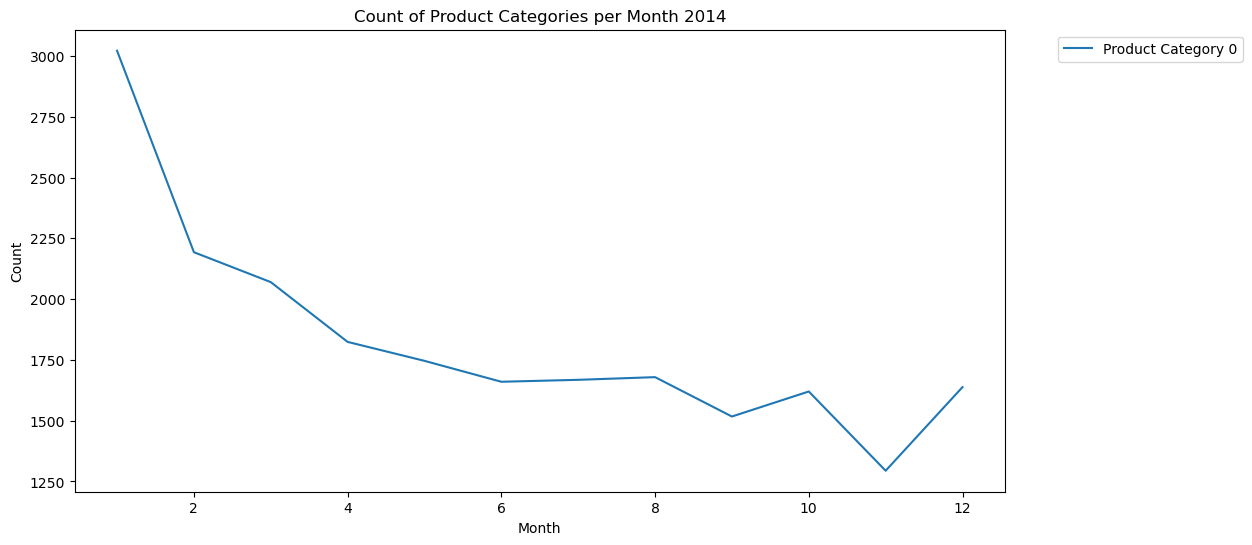

In [99]:
# PLotting all product category # counts in year 2014
df_pd = count_per_month.toPandas()

plt.figure(figsize=(12, 6))

# Loop product categories num and plot counts with different colors
for category in df_pd['product_category_num'].unique():
    df_cat = df_pd[df_pd['product_category_num'] == category]
    df_cat = df_cat.sort_values(by='month')
    plt.plot(df_cat['month'], df_cat['count'], label=f'Product Category {category}')

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Product Categories per Month 2014')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [100]:
from pyspark.sql.functions import year, month, count as spark_count

train_df_2 = train_df_1.filter(col('product_category_num') == 0)
train_df_2 = train_df_2.withColumn("year", year("review_date"))
train_df_2 = train_df_2.withColumn("month", month("review_date"))

# Group by 'year', 'month', and 'product_category_num' and count occurrences
count_per_month = train_df_2.groupBy("year", "month").agg(spark_count("*").alias("count"))

count_per_month.show()

#6-> 13649
#20 -> 611329

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2013|    9| 1517|
|2013|   10| 1620|
|2013|   12| 1638|
|2013|    7| 1668|
|2013|   11| 1294|
|2013|    8| 1679|
|2013|    2| 2193|
|2013|    3| 2070|
|2013|    6| 1660|
|2013|    4| 1824|
|2013|    5| 1746|
|2013|    1| 3022|
+----+-----+-----+



In [101]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
# Convert the PySpark DataFrame to Pandas DataFrame
count_per_month_pd = count_per_month.toPandas()
count_per_month_pd['date'] = pd.to_datetime(count_per_month_pd[['year', 'month']].assign(day=1))
count_per_month_pd.sort_values(by='date', inplace=True)

# Extract the time series data
series = count_per_month_pd['count']

# Fit ARIMA model
model = ARIMA(series, order=(5, 1, 0))  
model_fit = model.fit()

# 2015 Predictions 
forecast_steps = 8
forecast = model_fit.forecast(steps=forecast_steps) 
print("Forecast:", forecast)



Forecast: 12    1289.199368
13    1621.667059
14    1378.182153
15    1593.492982
16    1474.865100
17    1572.492111
18    1544.222689
19    1564.286875
Name: predicted_mean, dtype: float64


/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: Va

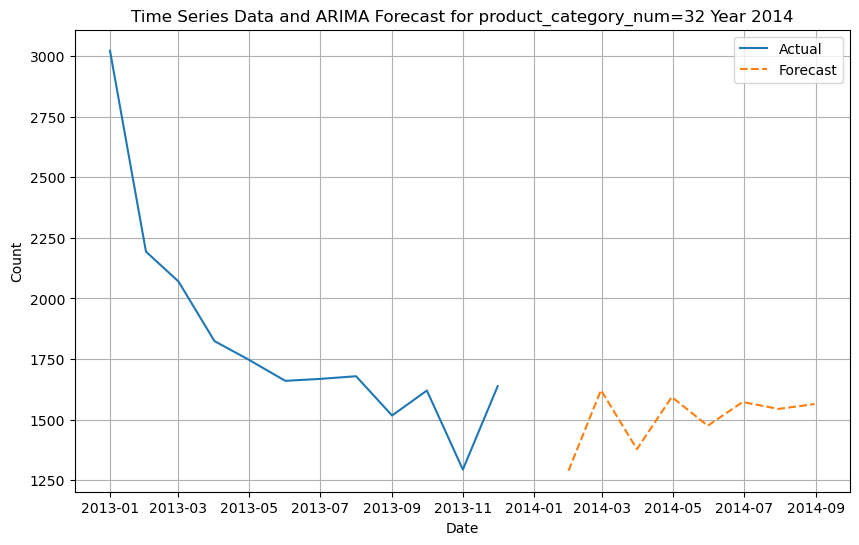

In [102]:
# time series data plot
plt.figure(figsize=(10, 6))
plt.plot(count_per_month_pd['date'], count_per_month_pd['count'], label='Actual')

# Plot the forecast
forecast_dates = pd.date_range(start=count_per_month_pd['date'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]
plt.plot(forecast_dates, forecast, label='Forecast', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Data and ARIMA Forecast for product_category_num=32 Year 2014')
plt.legend()

plt.grid(True)
plt.show()

# Data Evaluation
* Evaluate your model and compare training vs. test error

In [103]:
test_df= test.select(col('review_date'), col('product_category_num'))
test_df = test_df.withColumn("review_date", date_format(col("review_date"), "yyyy-MM"))
test_df = test_df.withColumn("year", year("review_date"))
test_df = test_df.withColumn("month", month("review_date"))
test_df_1 = test_df.filter((col('product_category_num') == 0))
test_df_1.show(3)


+-----------+--------------------+----+-----+
|review_date|product_category_num|year|month|
+-----------+--------------------+----+-----+
|    2015-08|                   0|2015|    8|
|    2015-08|                   0|2015|    8|
|    2015-08|                   0|2015|    8|
+-----------+--------------------+----+-----+
only showing top 3 rows



In [104]:
# Group by 'year', 'month', and 'product_category_num' and count occurrences
test_count_per_month = test_df_1.groupBy("year", "month").agg(spark_count("*").alias("count"))

test_count_per_month.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2015|    2| 2169|
|2015|    4| 1825|
|2015|    8| 1758|
|2015|    3| 2178|
|2015|    7| 1695|
|2015|    6| 1707|
|2015|    1| 2442|
|2015|    5| 1846|
+----+-----+-----+



In [105]:
test_count_per_month_pd = test_count_per_month.toPandas()
test_count_per_month_pd['date'] = pd.to_datetime(test_count_per_month_pd[['year', 'month']].assign(day=1))
test_count_per_month_pd.sort_values(by='date', inplace=True)

In [106]:
from math import sqrt
from sklearn.metrics import mean_squared_error

test_values = test_count_per_month.select('count').rdd.flatMap(lambda x: x).collect()
rmse = sqrt(mean_squared_error(test_values, forecast))
print('Test RMSE:', rmse)
# this is how off we predicted the actualy values. 

Test RMSE: 530.7096215042822


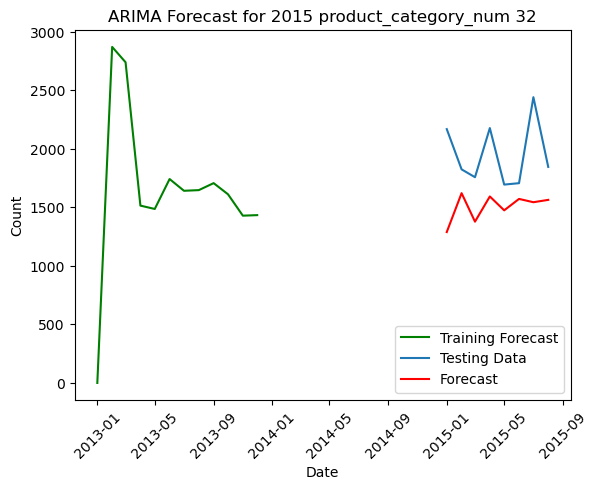

In [107]:
# Plot forecast, training, and testing data
plt.plot(count_per_month_pd['date'], model_fit.fittedvalues, color='green', label='Training Forecast')

test_dates = pd.to_datetime(test_count_per_month_pd[['year', 'month']].assign(day=1))
plt.plot(test_dates, test_values, label='Testing Data')

# Plot forecast
plt.plot(test_dates, forecast, color='red', label='Forecast')

plt.title('ARIMA Forecast for 2015 product_category_num 32')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

In [115]:
train_values = count_per_month.select('count').rdd.flatMap(lambda x: x).collect()

test_errors = []
train_errors = []

for i in range(0,5,1):
    model = ARIMA(series, order=(5+i, 1+i, i))
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=forecast_steps)
    train_rmse = sqrt(mean_squared_error(train_values, model_fit.fittedvalues))
    train_errors.append(train_rmse)
    
    test_rmse = sqrt(mean_squared_error(test_values, forecast))
    test_errors.append(test_rmse)

/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/work/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: Va

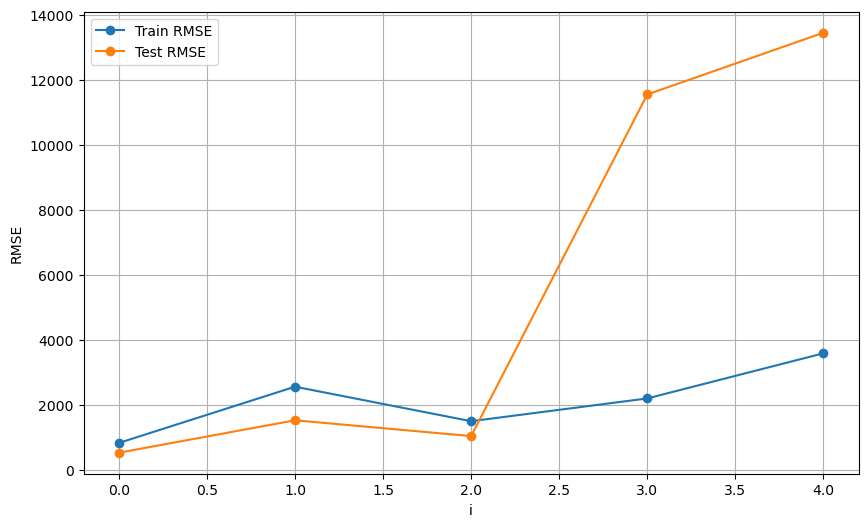

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(range(0,5,1), train_errors, label='Train RMSE', marker='o')
plt.plot(range(0,5,1), test_errors, label='Test RMSE', marker='o')
plt.xlabel('i')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Answer the questions
* Where does your model fit in the fitting graph? and What are the next models you are thinking of and why?

Based on the ARIMA model for product_category_num 32 of the year 2014, we forcasted the estimate of sales (with assumption based on reviews). The next models will include more training data, prior to 2014 for all product catgeories. We may possibily utilize the word2vector data to see the primary key words that have the highest count of reviews which we assume correlates to high counts of purchases. Through this we can forcast what speciifc item or product_category_num will increase in sales. However before moving on to more complicated models, our team will focus on building upon the ARIMA model to more acurately forcast which product_category_num is rise in sales/popular as the forcasted and test data concluded with a RMSE of 28498.15662477966. 

# Conclusion section
* What is the conclusion of your 1st model? What can be done to possibly improve it?

The 1st model concluded with an RMSE of 28498.156. This isn't the best given that there is almost a difference of 30k of the forcsted and the actualy 2015 test data for the product_category_num 32. We can increase the training data from 2014 to the range of 2010 to 2014. We do this for all the product_category_num to be able to accurately predict which item is more popular.  By increasing the training data we will be able to catch more underlying patterns thorughout the years. 